# Experiment 1: scaling of performance with data

For reference, the original paper is [here](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)

For the first experiment, we're just going to subsample the data and see how peformance changes as we increase the training set size.

In [527]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import math

%matplotlib inline
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

import pickle
import altair
import scipy

import glob
import re

from torch.utils.data.sampler import SubsetRandomSampler

In [336]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


### Helper functions

In [337]:
def get_dataset_size(start = 0.5, end = 100, base=2):
    """ Returns exponentially distributed dataset size vector"""
    dataset_size=[start]
    while True:
        dataset_size.append(dataset_size[-1]*base)
        if dataset_size[-1] > end:
            dataset_size[-1] = end
            break
    
    return dataset_size


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    

### Our simple ConvNet

In [484]:
class Net(nn.Module):
    def __init__(self, hyperparam_dict=None):
        
        super(Net, self).__init__()
        
        if not hyperparam_dict :
            hyperparam_dict = self.standard_hyperparams()
        
        self.hyperparam_dict = hyperparam_dict
        
        self.conv1 = nn.Conv2d(3, hyperparam_dict['conv1_size'], 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(hyperparam_dict['conv1_size'], hyperparam_dict['conv2_size'], 5)
        self.fc1 = nn.Linear(hyperparam_dict['conv2_size'] * 5 * 5, hyperparam_dict['fc1_size'])
        self.fc2 = nn.Linear(hyperparam_dict['fc1_size'], hyperparam_dict['fc2_size'])
        self.fc3 = nn.Linear(hyperparam_dict['fc2_size'], 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.hyperparam_dict['conv2_size'] * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    def standard_hyperparams(self):
        hyperparam_dict = {}
        
        hyperparam_dict['conv1_size'] = 6
        hyperparam_dict['conv2_size'] = 16
        
        hyperparam_dict['fc1_size'] = 120
        hyperparam_dict['fc2_size'] = 84
        
        return hyperparam_dict
        



### Model training and testing

In [539]:
def train_model(net, trainloader, valloader, n_val, n_epochs=10, lr=0.001, momentum=0.9, weight_decay=0.1):
    """ Take a model, run some number of training steps on some number of pieces of data.
    """
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay) 

    train_loss_list = []
    val_loss_list = []
    
    best_val_loss=10
    for epoch in range(n_epochs):  
        if epoch > 4 and (val_loss_list[-1] > val_loss_list[-2]) and (val_loss_list[-2] > val_loss_list[-3]) and (val_loss_list[-3] > val_loss_list[-4]):
            break
        epoch_start = time.time()
        running_loss = 0.0
        val_loss = 0.0
        for i_train, data in enumerate(trainloader, 0):
            
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data[0]
                

        eval_start = time.time()
        
        for i_val, data in enumerate(valloader, 0):
        
            if i_val> n_val:
                    break

            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # get output
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # print statistics
            val_loss += loss.data[0]

            
        train_loss_list.append(running_loss/i_train)
        val_loss_list.append(val_loss/i_val)
        print("Epoch %d done, avg_train_loss=%1.2f, avg_val_loss=%1.2f, batches=%d \n Took %1.2f minutes for training, %1.2f for eval."
              %(epoch, running_loss/i_train, val_loss/i_val, i_train, (eval_start-epoch_start)/60, (time.time() - eval_start)/60))
        
        if val_loss/i_val < best_val_loss:
            saved_net = net
            best_val_loss = val_loss/i_val
            
    print('Finished Training')
    
    # Return the net with the best loss
    print('Returning net with %1.3f loss'%best_val_loss)
    return saved_net, loss_list, val_loss_list

def test_model(net, testloader):
    """ Test a model on a dataset."""
    
    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_loss=0
    for data in testloader:
        inputs, orig_labels = data
        inputs, labels = Variable(inputs), Variable(orig_labels)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == orig_labels).sum()
        total_loss += loss.data[0]
    
    return correct/total, total_loss/total

def test_saved_model(dataset_size):
    """ Load a trained model and test it for a list of dataset sizes."""

    test_acc = {}
    val_acc = {}
    train_acc = {}
    test_loss = {}
    for train_size in dataset_size:
        net = torch.load('trainset_%1.2f_%d_images.model'%(train_size, train_size*total_train))
        print('Loaded model with subset %1.4f, which is %d images'%(train_size, train_size*total_train))

        accuracy, loss = test_model(net, testloader)

        print('Accuracy of the network on the 10000 test images: %d %%' % (
            100 * accuracy))

        test_acc[train_size] = accuracy
        test_loss[train_size] = loss

        del net # Attempt to free-up memory!
        
    return test_acc, test_loss

def test_best_saved_model(dataset_size):
    """ Retrieve the saved model with the best validation score."""

    test_acc = {}
    val_acc = {}
    train_acc = {}
    test_loss = {}

    for train_size in dataset_size:
        
        candidates = glob.glob('trainset_%d_images*.model'%(train_size*total_train))

        best_model = sorted(candidates, key = lambda  str: re.sub(".*loss", "", str))[0]
        
        net = torch.load(best_model)
        print('Loaded model %s' %(best_model))

        accuracy, loss = test_model(net, testloader)

        print('Accuracy of the network on the 10000 test images: %d %%' % (
            100 * accuracy))

        test_acc[train_size] = accuracy
        test_loss[train_size] = loss

        del net # Attempt to free-up memory!
        
    return test_acc, test_loss

def plot_results(test_acc, test_loss):
    
    plt.figure(figsize=(20,10))
    plt.style.use('seaborn-whitegrid')


    plt.subplot(121)
    plt.plot(dataset_size, list(test_acc.values()))
    plt.xlabel('Dataset Size')
    plt.ylabel('Accuracy')

    plt.subplot(122)
    ax = plt.loglog()
    plt.plot(dataset_size, list(test_acc.values()))
    plt.xlabel('log Dataset Size')
    plt.ylabel('log Accuracy')
    plt.suptitle('Dataset size vs. Accuracy', fontsize=30)


    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.plot(dataset_size, list(test_loss.values()))
    plt.xlabel('Dataset Size')
    plt.ylabel('Loss')

    plt.subplot(122)
    ax = plt.loglog()
    plt.plot(dataset_size, list(test_loss.values()))
    plt.xlabel('log Dataset Size')
    plt.ylabel('log Loss')
    plt.suptitle('Dataset size vs. Loss', fontsize=30)


## Subsample our data

In [519]:
val_size = 0.2

num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(val_size * num_train))

np.random.seed()
np.random.shuffle(indices)

train_idx, val_idx = indices[split:], indices[:split]
total_train = len(train_idx)

# For each of our train sets, we want a subset of the true train set
dataset_size = np.array(get_dataset_size())
dataset_size/=100 # Convert to ratios
train_set_samplers = dict()
for ts in dataset_size:
    train_set_samplers[ts]=np.random.choice(train_idx, int(ts*total_train))
    
val_sampler = SubsetRandomSampler(val_idx)



In [352]:
trainset_loaders = dict()
for ts in dataset_size:
    trainset_loaders[ts]=torch.utils.data.DataLoader(trainset, batch_size=4,
                                          sampler=train_set_samplers[ts], num_workers=2)

valloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          sampler=val_sampler, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Do a little inspection of the data

 ship  bird  ship plane


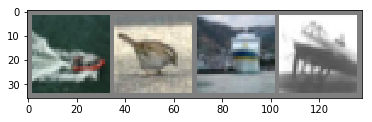

In [327]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Run  training

In [353]:
print(dataset_size)

[ 0.005  0.01   0.02   0.04   0.08   0.16   0.32   0.64   1.   ]


In [ ]:
test_acc = {}
val_acc = {}
train_acc = {}
test_loss = {}
for train_size in dataset_size:
    print('Training with subset %1.4f, which is %d images'%(train_size, train_size*total_train))
    net = Net()
    net, loss_list, val_list = train_model(net, trainset_loaders[train_size], valloader, 1000, n_epochs=10)
    test_accuracy, loss = test_model(net, testloader)
    
    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * accuracy))
    
    test_acc[train_size] = accuracy
    test_loss[train_size] = loss
    val_acc[train_size] = val_list
    train_acc[train_size] = loss_list
    
    
    torch.save(net, 'trainset_%1.2f_%d_images.model'%(train_size, train_size*total_train))
    del net # Attempt to free-up memory!

## Results
As expected, test set performance improves with dataset size.

However, when plotted on a log-log scale, this scaling is sub-linear: we get less bang-for-our-buck than one might expect given the increase in dataset size.

This is because we're naively using the same hyperparamters, which seem to work better for smaller datasets. In the second experiment we'll rectify this.

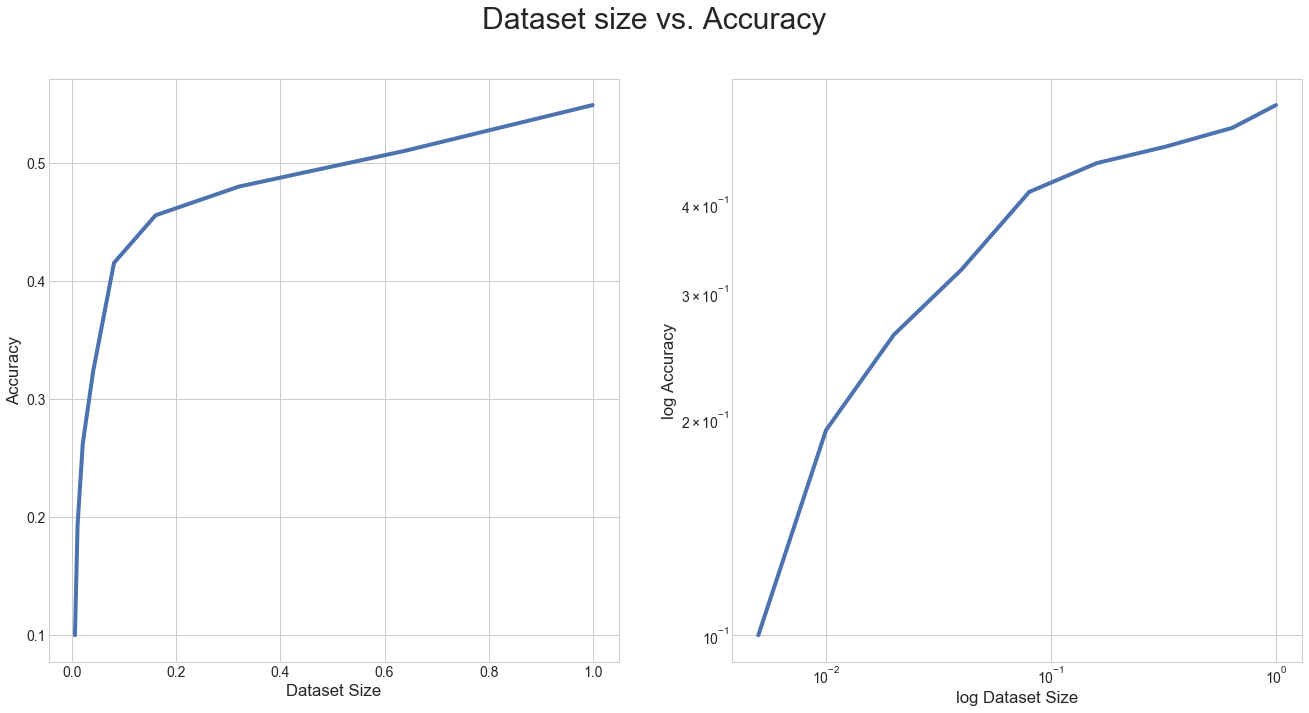

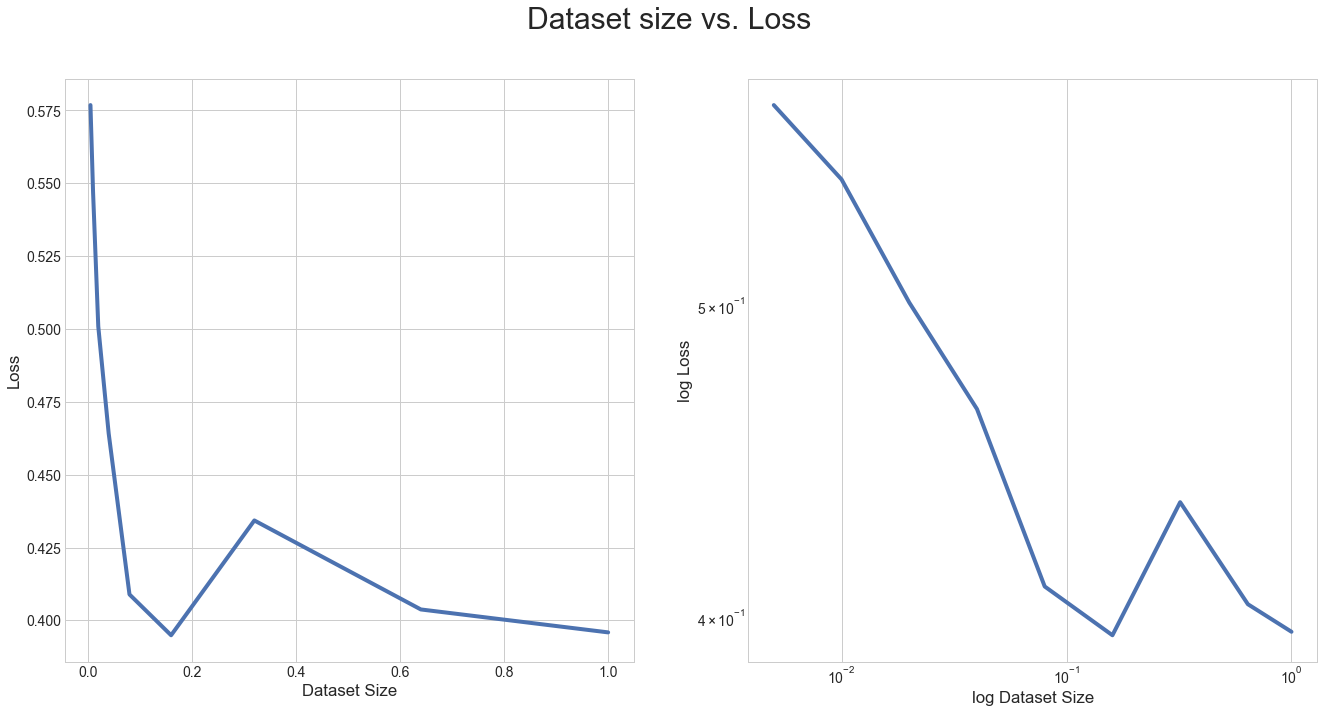

In [371]:
plot_results(test_acc, test_loss)
plt.show()

# Experiment 2
The best hyperparameter for each model depends critically upon the dataset size. We're going to do a little hyperparamter search using [random search](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf). 

In [533]:
def random_hyperparamters():
    
    hyperparam_dict = {}
    
    hyperparam_dict['lr'] = 10 ** np.random.uniform(-6, -1)
    hyperparam_dict['weight_decay'] = 10 ** np.random.uniform(-6, -3)
    hyperparam_dict['momentum'] = 10 ** np.random.uniform(-1, 0)
    
    hyperparam_dict['conv1_size'] = int(np.random.uniform(10,100))
    hyperparam_dict['conv2_size'] = int(np.random.uniform(10,100))
    hyperparam_dict['fc1_size'] = int(np.random.uniform(30,200))
    hyperparam_dict['fc2_size'] = int(np.random.uniform(30,200))

    return hyperparam_dict

In [ ]:
test_acc = {}
val_acc = {}
train_acc = {}
test_loss = {}

# Testing parameters
n_searches = 2
n_epochs = 1
n_val = 10

# Real parameters
n_searches = 20
n_epochs = 15
n_val = 500


for train_size in dataset_size:
    print('Training with subset %1.4f, which is %d images'%(train_size, train_size*total_train))
    
    test_acc[train_size] = []
    test_loss[train_size] = []
    val_acc[train_size] = []
    train_acc[train_size] = []
    
    for trial in range(n_searches):
        
        hyperparam_dict = random_hyperparamters()
        print(hyperparam_dict)
        
        net = Net(hyperparam_dict)
        
        net, loss_list, val_list = train_model(net, trainset_loaders[train_size], valloader, n_val, n_epochs=n_epochs,
                                              lr=hyperparam_dict['lr'], 
                                               momentum=hyperparam_dict['momentum'], 
                                               weight_decay=hyperparam_dict['weight_decay']
                                              )

        test_acc[train_size].append((hyperparam_dict, accuracy))
        test_loss[train_size].append((hyperparam_dict, loss)) 
        val_acc[train_size].append((hyperparam_dict, val_list)) 
        train_acc[train_size].append((hyperparam_dict, loss_list))


        torch.save(net, 'trainset_%d_images_trial%d_val_loss_%1.2f.model'%((train_size*total_train), trial, val_list[-1]))
        torch.save(hyperparam_dict, 'trainset_%d_images_trial%d_val_loss_%1.2f.hparams'%((train_size*total_train), trial, val_list[-1]))
        
        del net # Attempt to free-up memory!

# Assess the best model for each set size

In [ ]:
test_acc, test_loss = test_best_saved_model(dataset_size)

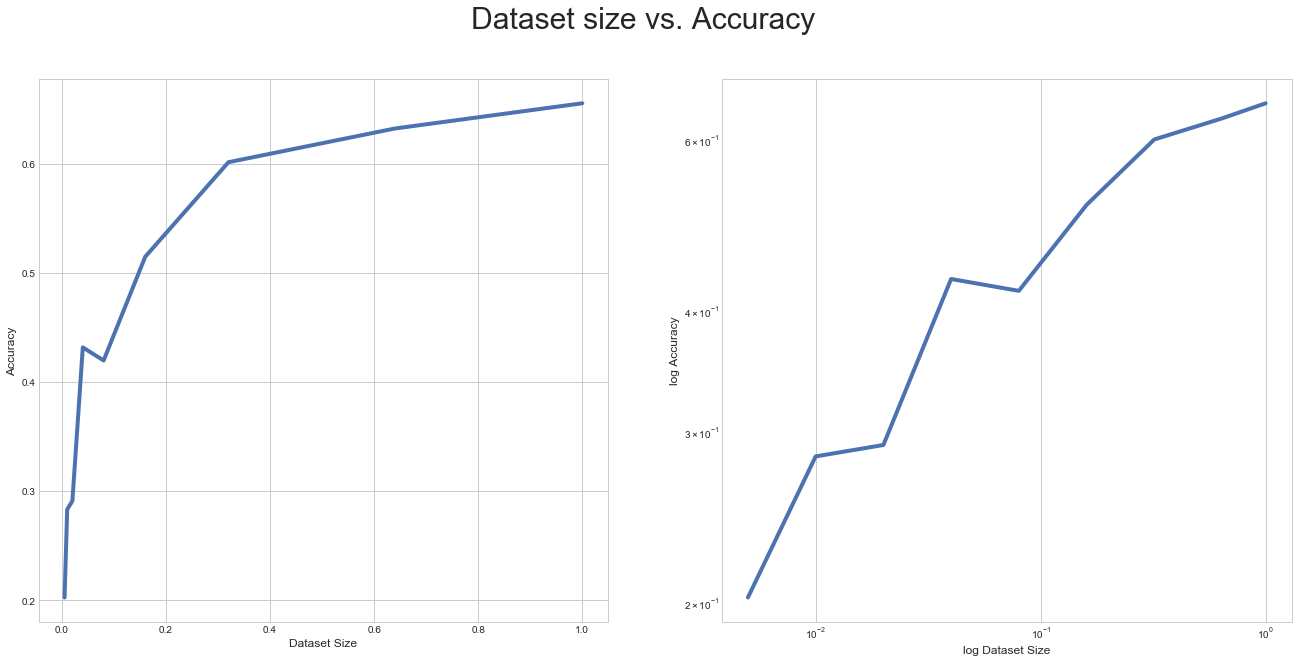

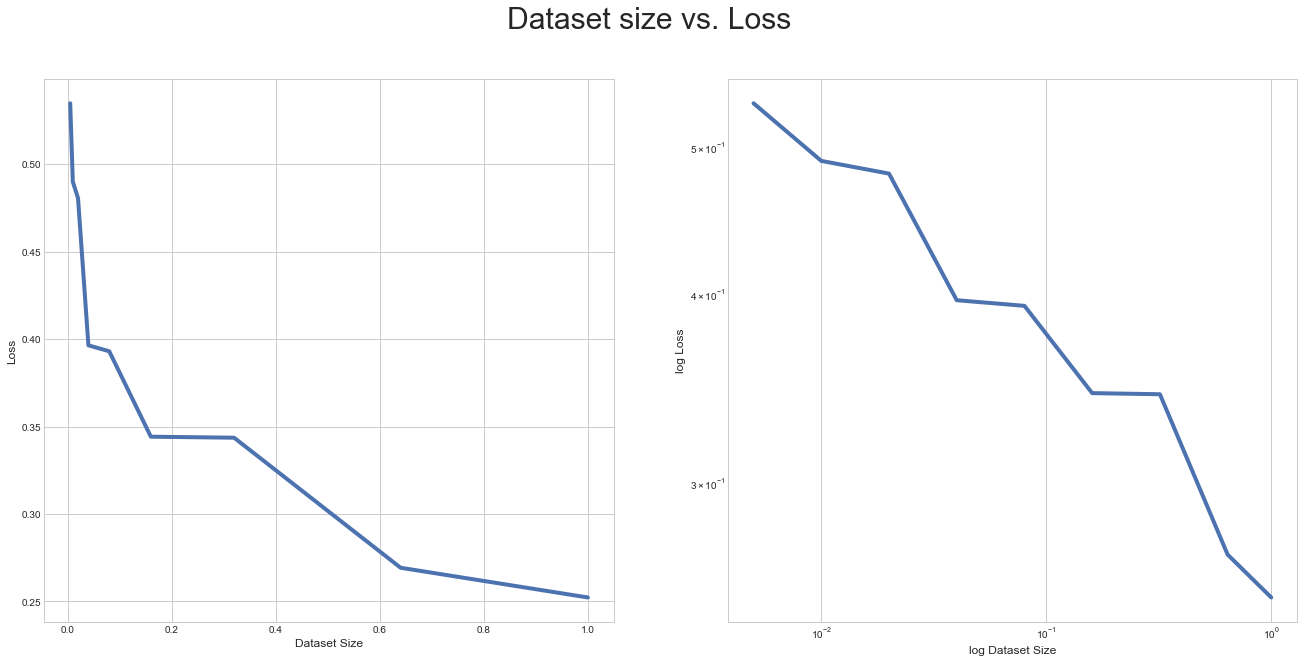

In [547]:
plot_results(test_acc, test_loss)